         Dummy | macro F1: 0.323 ± 0.020 | bal acc: 0.324
        LogReg | macro F1: 0.977 ± 0.009 | bal acc: 0.983
       SVM RBF | macro F1: 0.979 ± 0.012 | bal acc: 0.979
    RandForest | macro F1: 0.974 ± 0.013 | bal acc: 0.962
Selected best: SVM RBF (base)


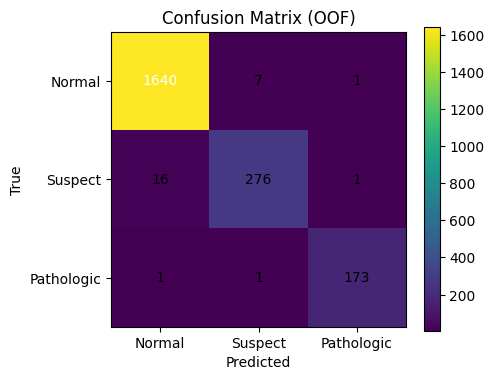

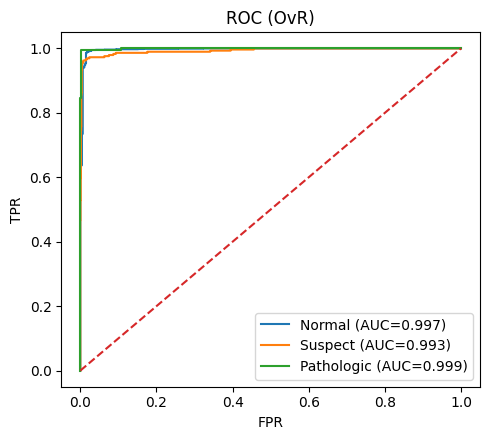

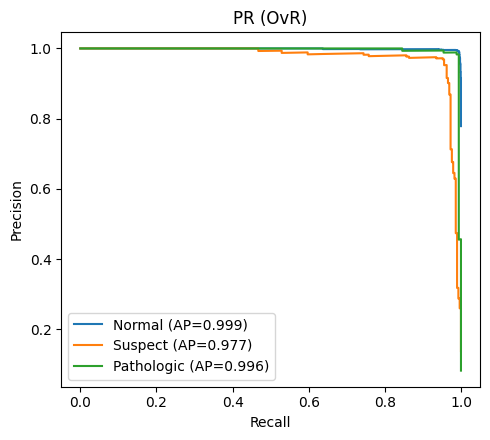

   class_id  class_name     ECE  ECE_macro
0         1      Normal  0.0067     0.0054
1         2     Suspect  0.0066     0.0054
2         3  Pathologic  0.0029     0.0054
            model  cv_macro_f1_mean  cv_macro_f1_std  cv_balacc_mean  \
2  SVM RBF (base)          0.979475         0.012156        0.978956   
1   LogReg (base)          0.976610         0.008700        0.983156   
3       RF (base)          0.973730         0.013362        0.962167   
0           Dummy          0.323301         0.020355        0.324184   

   cv_balacc_std  
2       0.008842  
1       0.009371  
3       0.018303  
0       0.020307  
Saved -> ctg_best_calibrated.joblib
     feature  importance       std
32        fs    0.133537  0.004693
34     class    0.120196  0.003748
31        ld    0.114672  0.004188
5         ac    0.030108  0.004141
30        de    0.019210  0.001568
12        dl    0.016254  0.003394
29        ad    0.010623  0.001692
7         uc    0.008022  0.001883
26         a    0.005

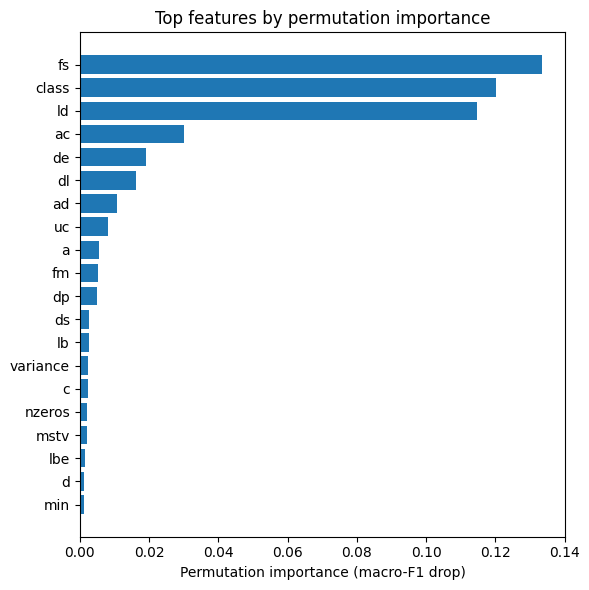

Δ macro-F1 with 1% noise: -0.0011


In [9]:
# --- SETUP ---
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import joblib

from ctg_prep import make_preprocess_trees, make_preprocess_linear   # your module
# if you already have evaluate() in ctg_eval, you can import it; else we use the one below

FIG_DIR = Path("reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

# Optional: don’t crash if boost libs missing
try:
    from xgboost import XGBClassifier; xgb_ok = True
except Exception:
    xgb_ok = False
try:
    from lightgbm import LGBMClassifier; lgbm_ok = True
except Exception:
    lgbm_ok = False
try:
    from catboost import CatBoostClassifier; cat_ok = True
except Exception:
    cat_ok = False

# --- DATA ---
df = pd.read_csv("CTG_clean.csv")
df = df[df["NSP"].notna()].copy()
df["NSP"] = df["NSP"].astype(int)
y = df["NSP"].values
X = df.drop(columns=["NSP", "filename", "segfile"], errors="ignore")

# --- CV + scoring ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "macro_f1": make_scorer(f1_score, average="macro"),
    "bal_acc": make_scorer(balanced_accuracy_score)
}

def evaluate(pipe, X, y, name):
    res = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False)
    print(f"{name:>14} | macro F1: {res['test_macro_f1'].mean():.3f} ± {res['test_macro_f1'].std():.3f} | bal acc: {res['test_bal_acc'].mean():.3f}")
    return res

# --- MODELS (same preprocessing across ladder) ---
pipe_dummy = Pipeline([("prep", make_preprocess_linear()), ("clf", DummyClassifier(strategy="stratified", random_state=42))])
pipe_lr    = Pipeline([("prep", make_preprocess_linear()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", multi_class="multinomial", solver="lbfgs"))])
pipe_svm   = Pipeline([("prep", make_preprocess_linear()), ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))])
pipe_rf    = Pipeline([("prep", make_preprocess_trees()),  ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced_subsample", random_state=42))])

# Evaluate baseline ladder
res_dummy = evaluate(pipe_dummy, X, y, "Dummy")
res_lr    = evaluate(pipe_lr,    X, y, "LogReg")
res_svm   = evaluate(pipe_svm,   X, y, "SVM RBF")
res_rf    = evaluate(pipe_rf,    X, y, "RandForest")

# Optional: quick randomized searches (comment out if no time)
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import loguniform, randint
# ... (skip to finish fast)

# --- PICK BEST BY MACRO-F1 ---
candidates = [
    ("Dummy", pipe_dummy, res_dummy),
    ("LogReg (base)", pipe_lr, res_lr),
    ("SVM RBF (base)", pipe_svm, res_svm),
    ("RF (base)", pipe_rf, res_rf),
]
best_name, best_pipe, _ = max(candidates, key=lambda t: t[2]["test_macro_f1"].mean())
print("Selected best:", best_name)

# --- OOF PREDICTIONS + CORE FIGURES ---
classes = np.sort(np.unique(y))
label_names = ["Normal","Suspect","Pathologic"]  # assumes classes sorted as 1,2,3; adjust if needed

oof_prob = cross_val_predict(best_pipe, X, y, cv=skf, method="predict_proba", n_jobs=-1)
oof_pred = classes[oof_prob.argmax(axis=1)]

# Confusion matrix
cm = confusion_matrix(y, oof_pred, labels=classes)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (OOF)")
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, label_names); plt.yticks(ticks, label_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color=("white" if cm[i,j] > cm.max()/2 else "black"))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
plt.savefig(FIG_DIR/"confusion_matrix_oof.png", dpi=160); plt.show()

# Per-class report CSV
report = classification_report(y, oof_pred, labels=classes, target_names=label_names, output_dict=True, zero_division=0)
pd.DataFrame(report).T.to_csv(FIG_DIR/"per_class_f1_oof.csv")

# ROC / PR (OvR)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
plt.figure(figsize=(5,4.5))
for i, cls in enumerate(classes):
    y_bin = (y == cls).astype(int)
    fpr, tpr, _ = roc_curve(y_bin, oof_prob[:, i])
    plt.plot(fpr, tpr, label=f"{label_names[i]} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],"--"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (OvR)"); plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR/"roc_ovr.png", dpi=160); plt.show()

plt.figure(figsize=(5,4.5))
for i, cls in enumerate(classes):
    y_bin = (y == cls).astype(int)
    prec, rec, _ = precision_recall_curve(y_bin, oof_prob[:, i])
    ap = average_precision_score(y_bin, oof_prob[:, i])
    plt.plot(rec, prec, label=f"{label_names[i]} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (OvR)"); plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR/"pr_ovr.png", dpi=160); plt.show()

# --- CALIBRATION + ECE (simple) ---
from sklearn.calibration import calibration_curve
def expected_calibration_error(y_true_bin, y_prob, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = (bin_ids == b)
        if not np.any(mask): 
            continue
        ece += abs((y_true_bin[mask]==1).mean() - y_prob[mask].mean()) * mask.mean()
    return ece

rows = []
for i, cls in enumerate(classes):
    y_bin = (y == cls).astype(int)
    frac_pos, mean_pred = calibration_curve(y_bin, oof_prob[:, i], n_bins=15, strategy="uniform")
    ece_k = expected_calibration_error(y_bin, oof_prob[:, i], n_bins=15)
    rows.append({"class_id": int(cls), "class_name": label_names[i], "ECE": round(ece_k, 4)})

calib_df = pd.DataFrame(rows); calib_df["ECE_macro"] = calib_df["ECE"].mean()
calib_df.to_csv(FIG_DIR/"calibration_ece_oof.csv", index=False)
print(calib_df)


# --- SAVE COMPARISON TABLE ---
rows_cmp = []
def addrow(name, res):
    rows_cmp.append({
        "model": name,
        "cv_macro_f1_mean": float(res["test_macro_f1"].mean()),
        "cv_macro_f1_std":  float(res["test_macro_f1"].std()),
        "cv_balacc_mean":   float(res["test_bal_acc"].mean()),
        "cv_balacc_std":    float(res["test_bal_acc"].std()),
    })
for name, pipe, res in candidates:
    addrow(name, res)
cmp_df = pd.DataFrame(rows_cmp).sort_values("cv_macro_f1_mean", ascending=False)
cmp_df.to_csv("reports/model_comparison.csv", index=False)
print(cmp_df)

# --- CALIBRATE & SAVE FINAL MODEL ---
calibrated = CalibratedClassifierCV(estimator=best_pipe, method="sigmoid", cv=5)
calibrated.fit(X, y)
joblib.dump(calibrated, "ctg_best_calibrated.joblib")
print("Saved -> ctg_best_calibrated.joblib")

# --- PERMUTATION IMPORTANCE (global explainability) ---
from sklearn.base import clone
from sklearn.inspection import permutation_importance

# Fit the best pipeline (again) on full data
best_pipe_fit = clone(best_pipe).fit(X, y)

r = permutation_importance(
    best_pipe_fit,
    X, y,
    scoring="f1_macro",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

pi = pd.DataFrame({
    "feature": X.columns,
    "importance": r.importances_mean,
    "std": r.importances_std
}).sort_values("importance", ascending=False)

# Save results
pi.to_csv(FIG_DIR / "permutation_importance_original.csv", index=False)
print(pi.head(20))

# Plot top 20
plt.figure(figsize=(6,6))
plt.barh(pi.head(20)["feature"][::-1], pi.head(20)["importance"][::-1])
plt.xlabel("Permutation importance (macro-F1 drop)")
plt.title("Top features by permutation importance")
plt.tight_layout()
plt.savefig(FIG_DIR / "permutation_importance_top20_original.png", dpi=160)
plt.show()


# --- ROBUSTNESS (1% noise) ---
from sklearn.base import clone
from sklearn.metrics import f1_score

# 1️⃣ Fit a copy of the pipeline
best_pipe_fit = clone(best_pipe).fit(X, y)

# 2️⃣ Create noisy data
rng = np.random.default_rng(42)
X_num = X.select_dtypes(include=[np.number])
X_noise = X.copy()
X_noise[X_num.columns] = X_num + rng.normal(0, X_num.std(ddof=0)*0.01, size=X_num.shape)

# 3️⃣ Predict with the FITTED copy
y_pred0 = best_pipe_fit.predict(X)
y_pred1 = best_pipe_fit.predict(X_noise)

# 4️⃣ Compute and save the delta
delta = f1_score(y, y_pred1, average="macro") - f1_score(y, y_pred0, average="macro")
print(f"Δ macro-F1 with 1% noise: {delta:.4f}")

from pathlib import Path
Path("reports").mkdir(exist_ok=True)
with open("reports/robustness.txt", "w") as f:
    f.write(f"Delta macro-F1 with 1% numeric noise: {delta:.4f}\n")